In [1]:
# !pip install gymnasium

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

#notebook specific
%matplotlib inline


In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Create the MountainCarContinuous environment
env = gym.make('MountainCarContinuous-v0')

# Set parameters
num_episodes = 500
learning_rate = 0.001  # Lower learning rate for stability in continuous action space
gamma = 0.99

cuda


In [4]:
class TileCoder:
    def __init__(self, position_range, velocity_range, num_tilings, num_tiles):
        self.position_range = position_range
        self.velocity_range = velocity_range
        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        
        self.tile_width = (position_range[1] - position_range[0]) / (num_tiles - 1)
        self.tile_height = (velocity_range[1] - velocity_range[0]) / (num_tiles - 1)
        
        self.offsets = np.linspace(0, self.tile_width * (num_tilings - 1) / num_tilings, num_tilings)
        
    def get_tile_indices(self, position, velocity):
        tile_indices = []
        for offset in self.offsets:
            tile_x = int((position - self.position_range[0] + offset) / self.tile_width)
            tile_y = int((velocity - self.velocity_range[0] + offset) / self.tile_height)
            tile_indices.append((tile_x % self.num_tiles, tile_y % self.num_tiles))
        return tile_indices
    
    def get_feature_vector(self, position, velocity):
        tile_indices = self.get_tile_indices(position, velocity)
        feature_vector = np.zeros(self.num_tilings * self.num_tiles * self.num_tiles)
        for tiling, (tile_x, tile_y) in enumerate(tile_indices):
            index = tiling * self.num_tiles * self.num_tiles + tile_y * self.num_tiles + tile_x
            feature_vector[index] = 1
        return feature_vector


In [5]:
position_range = env.observation_space.low[0], env.observation_space.high[0]
velocity_range = env.observation_space.low[1], env.observation_space.high[1]

# Initialize TileCoder
num_tilings = 8
num_tiles = 8
feature_vector_size = num_tilings * num_tiles * num_tiles
print(feature_vector_size)
tile_coder = TileCoder(position_range, velocity_range, num_tilings, num_tiles)

512


In [6]:
# Define the policy network for continuous action space using Gaussian distribution
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 24)
        self.fc3 = nn.Linear(24, output_dim)
        self.log_std = nn.Parameter(torch.zeros(output_dim))  # Learnable log standard deviation

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = torch.tanh(self.fc3(x))
        std = torch.exp(self.log_std)
        return mean, std
    
    # Saving the model
    def save_model(self, path):
        torch.save(self.state_dict(), path)
    
    # Loading the model
    def load_model(self, path):
        self.load_state_dict(torch.load(path))

In [7]:
# Initialize policy network and optimizer
policy_net = PolicyNetwork(feature_vector_size, env.action_space.shape[0]).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [8]:
# Function to choose action based on policy
def choose_action(state):
    feature_vector = tile_coder.get_feature_vector(state[0], state[1])
    feature_vector = torch.tensor(feature_vector, dtype=torch.float32).unsqueeze(0).to(device)
    mean, std = policy_net(feature_vector)
    normal = torch.distributions.Normal(mean, std)
    action = normal.sample()
    log_prob = normal.log_prob(action).sum()
    return action.detach().cpu().numpy().flatten(), log_prob

# Function to compute the baseline (moving average)
def compute_baseline(all_rewards, window_size=100):
    if len(all_rewards) < window_size:
        baseline = np.mean(all_rewards)
    else:
        baseline = np.mean(all_rewards[-window_size:])
    return baseline

# Function to compute the discounted rewards
def discount_rewards(rewards, gamma=0.99):
    G = 0
    discounted_rewards = []
    for reward in reversed(rewards):
        G = reward + gamma * G
        discounted_rewards.insert(0, G)
    discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32).to(device)
    return discounted_rewards

    # REINFORCE Algorithm
def train_policy_net(policy_net, num_episodes=2000, gamma=0.99, lr=0.01, baseline_window=100, max_episode_length=5000):
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    all_rewards = []
    
    for episode in range(num_episodes):
        # Step 1: Generate an episode S0, A0, R1, ..., ST-1, AT-1, RT
        state = env.reset()[0]
        rewards, log_probs = [], []
        done = False
        
        # Generate an episode
        for step in range(max_episode_length):  # Limit the episode length
            # Step 2: Use policy to sample actions
            action, log_prob = choose_action(state)
            next_state, reward, done, _, _ = env.step(action)
            # Store states, actions, rewards, and log probabilities
            rewards.append(reward)
            log_probs.append(log_prob)
    
            state = next_state
            if done:
                print("finished")
                break
                
         # If the episode is truncated
        if not done:
            print(f"Episode {episode+1} truncated at {max_episode_length} steps")
        
        # Convert lists to arrays
        rewards = np.array(rewards)
        log_probs = torch.stack(log_probs)
        all_rewards.append(rewards.sum())

        # Step 3: Compute discounted rewards G
        G = discount_rewards(rewards, gamma)

        # Step 4: Compute baseline
        baseline = compute_baseline(all_rewards, baseline_window)
        baseline = torch.tensor(baseline, dtype=torch.float32).to(device)

        # Step 5: Compute advantages by subtracting baseline from G
        advantages = G - baseline

        # Step 6: Update policy parameters
        optimizer.zero_grad()
        loss = -torch.sum(log_probs * advantages) # compute the loss:    loss = - Σ( log( π(At | St, θ) ) * advantages )
        loss.backward()  # apply the gradients to the network parameters
        optimizer.step() # gradient ascent step:        θ = θ + α * gradients
    
        # Print episode information
        print(f'Episode: {episode+1}, Total Reward: {np.sum(rewards)}, Loss: {loss.detach().cpu().numpy().flatten()}')
        
        # Optional: Save intermediate models to monitor progress
        if episode % 100 == 0:
            policy_net.save_model(f'policy_net2_episode_{episode}.pth')
        
    # Save the model
    policy_net.save_model('policy_net2.pth')    
    env.close()

In [17]:
policy_net.load_model('policy_net_episode_4300.pth')

In [ ]:
# Train the policy network
train_policy_net(policy_net)

In [ ]:
policy_net.save_model('policy_net.pth')   

In [ ]:
# Function to visualize the policy
def visualize_policy(policy_net):   
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 250)
    v = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 250)
    X, V = np.meshgrid(x, v)
    actions = np.zeros_like(X, dtype=np.float32)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            state = np.array([X[i, j], V[i, j]])
            feature_vector = tile_coder.get_feature_vector(state[0], state[1])
            feature_vector = torch.tensor(feature_vector, dtype=torch.float32).unsqueeze(0).to(device)
            mean, std = policy_net(feature_vector)
            action = mean.detach().cpu().numpy().flatten()[0]  # Use mean action for visualization
            actions[i, j] = action

    plt.figure(figsize=(10, 8))
    plt.contourf(X, V, actions, levels=100, cmap='coolwarm')
    plt.colorbar()
    plt.xlabel('Position (x)')
    plt.ylabel('Velocity (v)')
    plt.title('Learned Policy Visualization')
    plt.show()

# Visualize the policy
visualize_policy(policy_net)

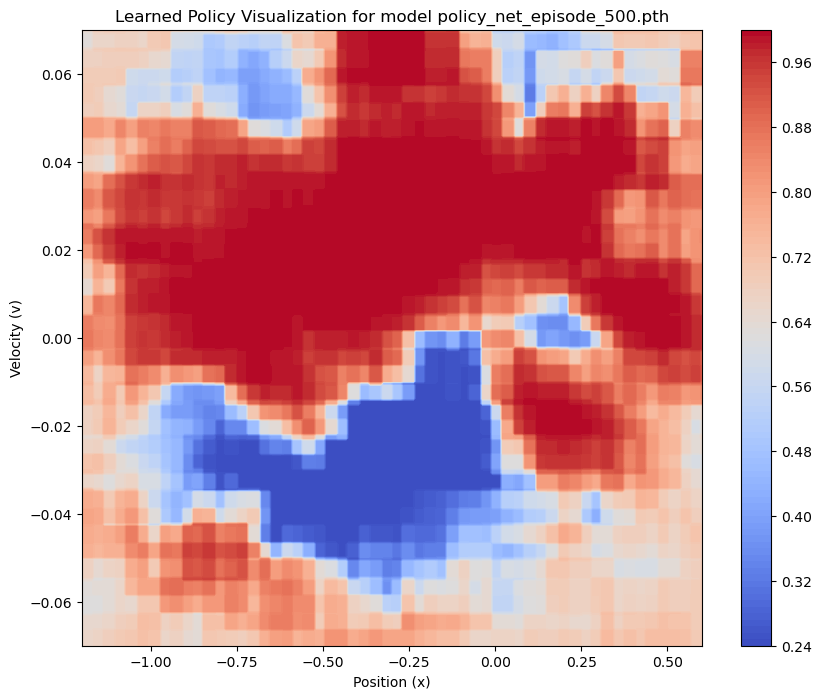

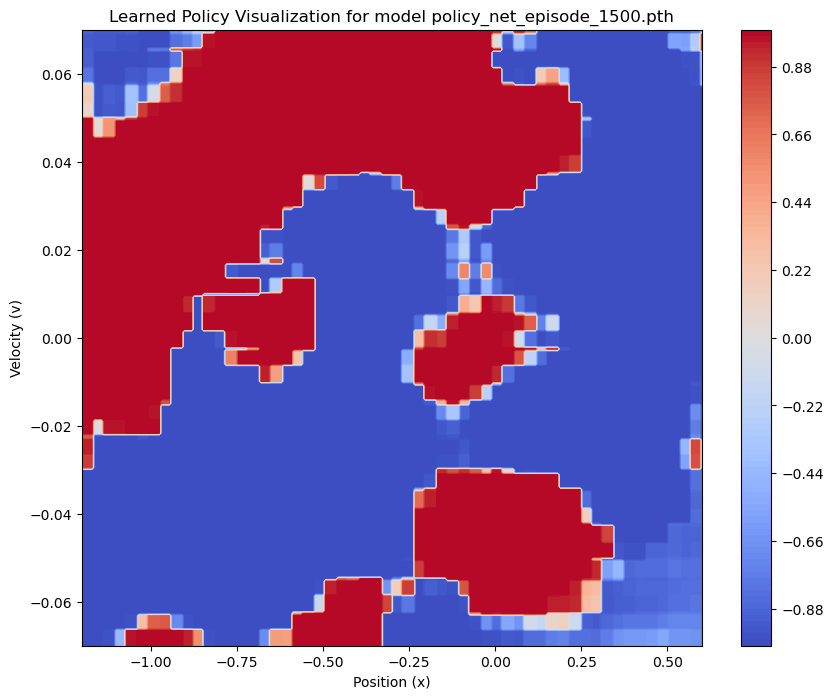

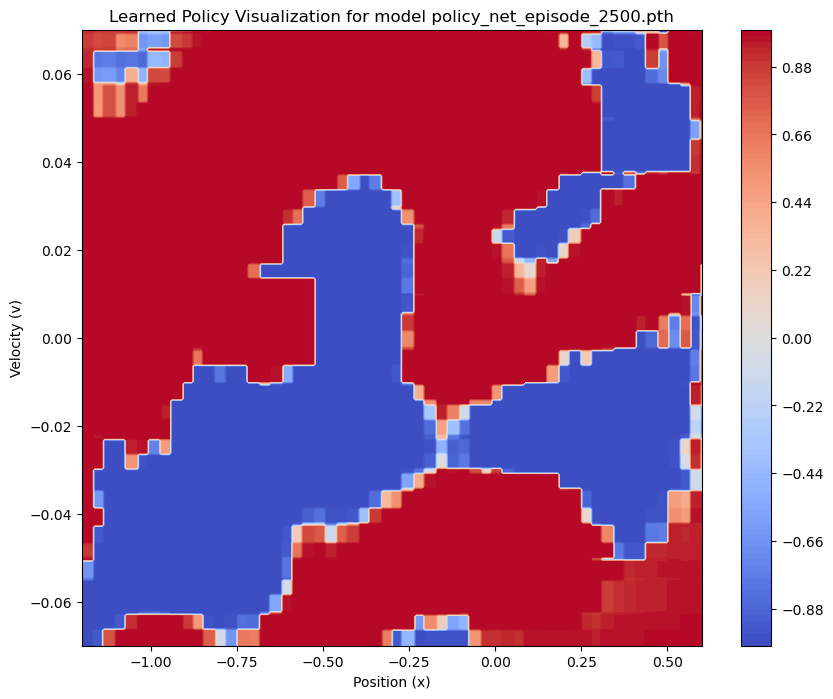

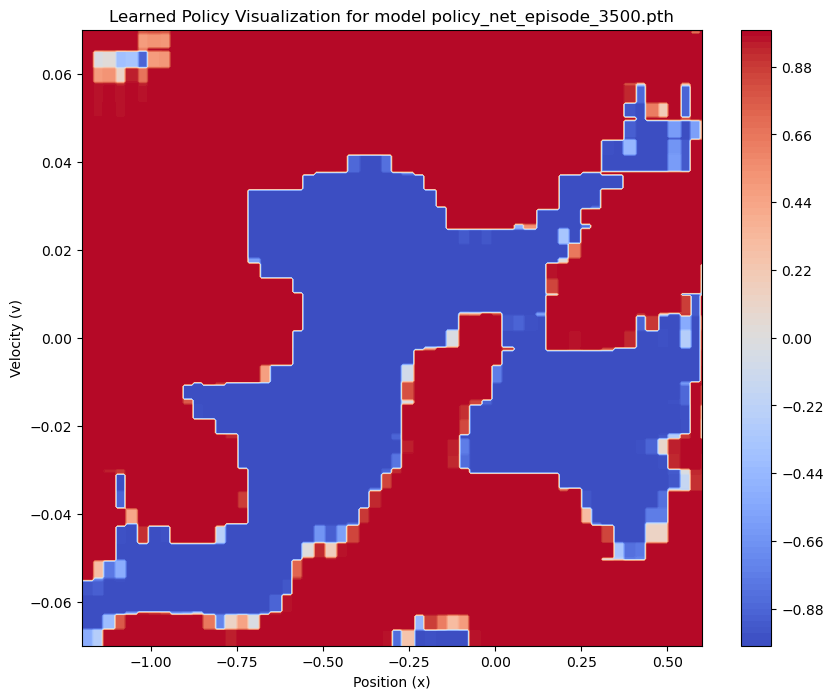

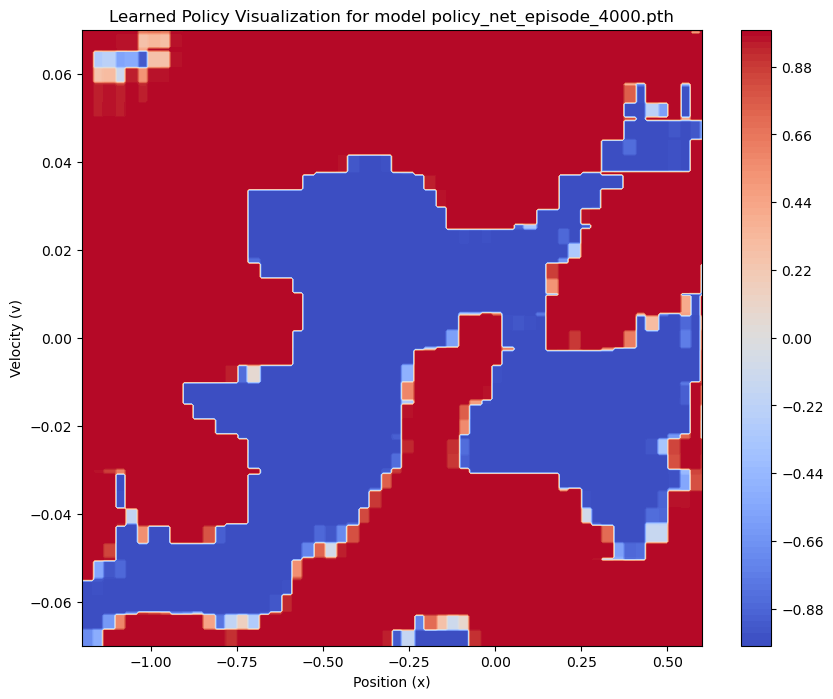

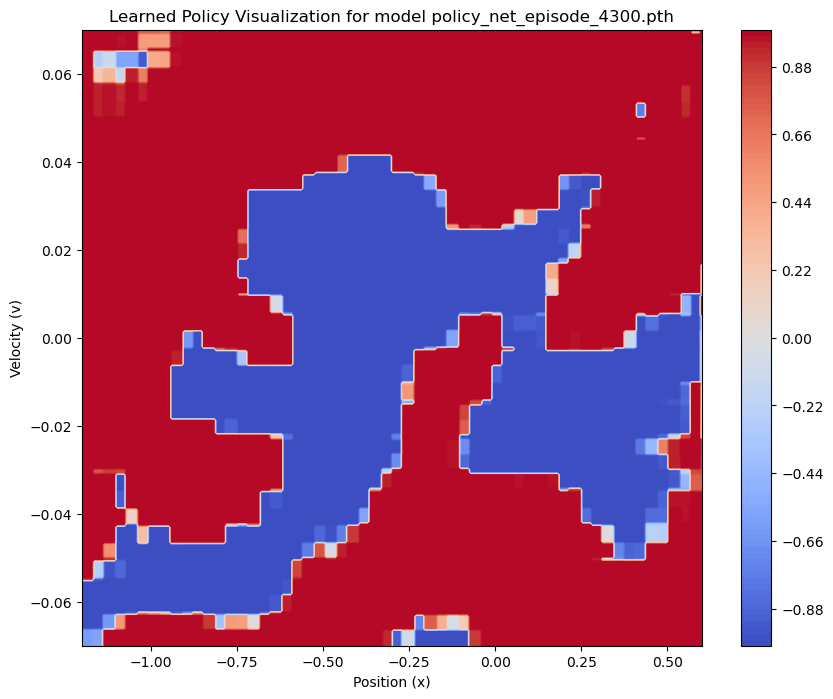

In [10]:
def visualize_policy_for_models(policy_net, model_paths):
    for model_path in model_paths:
        policy_net.load_model(model_path)
        x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 250)
        v = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 250)
        X, V = np.meshgrid(x, v)
        actions = np.zeros_like(X, dtype=np.float32)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                state = np.array([X[i, j], V[i, j]])
                feature_vector = tile_coder.get_feature_vector(state[0], state[1])
                feature_vector = torch.tensor(feature_vector, dtype=torch.float32).unsqueeze(0).to(device)
                mean, std = policy_net(feature_vector)
                action = mean.detach().cpu().numpy().flatten()[0]  # Use mean action for visualization
                actions[i, j] = action

        plt.figure(figsize=(10, 8))
        plt.contourf(X, V, actions, levels=100, cmap='coolwarm')
        plt.colorbar()
        plt.xlabel('Position (x)')
        plt.ylabel('Velocity (v)')
        plt.title(f'Learned Policy Visualization for model {model_path}')
        plt.show()
    
model_paths = ['policy_net_episode_500.pth', 'policy_net_episode_1500.pth', 'policy_net_episode_2500.pth', 'policy_net_episode_3500.pth', 'policy_net_episode_4000.pth', 'policy_net_episode_4300.pth']
visualize_policy_for_models(policy_net, model_paths)